# Part 2 of my Drug Review Dataset Exploration
By Britton Winterrose

In [1]:
# If in GOOGLE COLAB
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

notebookname = "Drug_Data_"
variant = "LSTM_w_stopwords_"
version = "1.0_"
title = notebookname + variant + version
print (title)

#Data Source Citation:
#Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. DOI: [Web Link]

Drug_Data_LSTM_w_stopwords_1.0_


# Import the libraries


In [2]:
import pandas as pd
import numpy as np
import re, string, unicodedata

!pip install inflect --upgrade
!pip install tqdm --upgrade

import inflect
from string import punctuation
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import h5py
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from keras.models import Model, Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

%matplotlib inline


Requirement already up-to-date: inflect in c:\users\britt\appdata\local\conda\conda\envs\ml\lib\site-packages (2.1.0)
Requirement already up-to-date: tqdm in c:\users\britt\appdata\local\conda\conda\envs\ml\lib\site-packages (4.28.1)


Using TensorFlow backend.


In [3]:
nltk.download('stopwords')

drug_stopwords = pd.read_csv('drugname_stopwords.csv')
drug_stopwords = drug_stopwords["0"].tolist()
print(drug_stopwords)

MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 3000
EMBEDDING_DIM = 160

# max_words = 3500
# max_len = 180
# embedding_vector_length = 160


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\britt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['acetaminophen', 'pseudoephedrine', 'phenylephrine', 'estradiol', 'dextromethorphan', 'codeine', 'hydrochlorothiazide', 'chlorpheniramine', 'guaifenesin', 'metformin', 'ethinyl', 'mucinex', 'hydrocortisone', 'peroxide', 'amlodipine', 'diphenhydramine', 'tylenol', 'tenofovir', 'polymyxin', 'dha', 'hfa', 'benzoyl', 'advil', 'vicks', 'butalbital', 'loestrin', 'emtricitabine', 'lidocaine', 'salicylate', 'salicylic', 'odt', 'naproxen', 'claritin', 'senna', 'hyoscyamine', 'sudafed', 'estrogens', 'valsartan', 'brompheniramine', 'dexamethasone', 'gildess', 'intensol', 'hct', 'junel', 'afrin', 'globulin', 'neomycin', 'simethicone', 'excedrin', 'methenamine', 'depo', 'promethazine', 'microgestin', 'nizoral', 'monistat', 'naloxone', 'respimat', 'norethindrone', 'pyrilamine', 'ellipta', 'atropine', 'olmesartan', 'lamivudine', 'hydroxide', 'oxycodone', 'provera', 'fluticasone', 'levonorgestrel', 'bacitracin', 'ibuprofen', 'bisacodyl', 'doxylamine', 'menthol', 'multivitamin', 'pramoxine', 'bicarbon

# Read in data

In [30]:
# Uncomment for first run.
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
#!unzip drugsCom_raw.zip

train_df = pd.read_table('drugsComTrain_raw.tsv')
test_df = pd.read_table('drugsComTest_raw.tsv')

## Rating to good/bad



In [68]:
def rank_bin(array):
  y_rank = []
  for i in array:
    if i <= 4: # Negative Rating Cut Off (Inclusive)
      y_rank.append('Negative')
    elif i >= 7: # Positive Rating Cut Off (Inclusive)
      y_rank.append('Positive')
    else:
      y_rank.append('Neutral')
  return y_rank

# Assign test & train data their classes.
train_df['classes_to_predict'] = rank_bin(train_df['rating'])
test_df['classes_to_predict'] = rank_bin(test_df['rating'])

# Make a variable to contain the class labels.
classes_to_predict = ['Positive','Negative','Neutral']
print(train_df['classes_to_predict'].value_counts())
print(test_df['classes_to_predict'].value_counts()) # Check to see the bin sizes. 

Positive    106866
Negative     40075
Neutral      14356
Name: classes_to_predict, dtype: int64
Positive    35440
Negative    13497
Neutral      4829
Name: classes_to_predict, dtype: int64


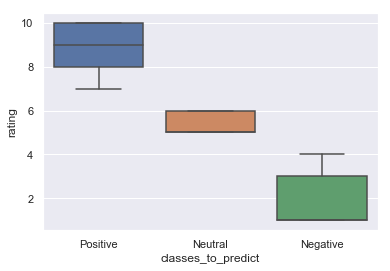

In [6]:
# Show the coverage for each group by its rating.
sns.boxplot(x='classes_to_predict', y="rating", data=train_df)
plt.show()

In [7]:
train_df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,classes_to_predict
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,Positive
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,Positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,Neutral
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,Positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,Positive


## Preprocess the text data


In [8]:
print('Readying the preprocessing functions')

# Regex for removing non-alphanumeric characters and spaces
remove_special_char = re.compile('r[^a-z\d]',re.IGNORECASE)

# Regex to replace all numerics
replace_numerics = re.compile(r'\d+',re.IGNORECASE)

# F&#K Unicode Emojis
emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\u200d"
                       u"\u2640-\u2642" 
                       "]+", flags=re.UNICODE)

# Load NLTK stop words
stop_words = nltk.corpus.stopwords.words('english')
print ("NLTK stopword list length: ",len(stop_words),'words')

# Add custom drug stopwords
stop_words.extend(drug_stopwords)
print ("Added custom stopwords")
print ("New stopword list length: ",len(stop_words),'words')



#######################################################
#NORMALIZER, RUNS IN PREPROCESS
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words


# Define Text-PreProcessing function
#################################################################
def preprocess_text(text, remove_stopwords = True, perform_stemming = True):
    #first clean text then go to lowercase and split.
    text = text.replace(r"http\S+", "")
    text = text.replace(r"http", "")
    text = text.replace(r"(\d)", "")
    text = text.replace(r"@\S+", "")
    text = text.replace(r"@", "at")
    text = remove_special_char.sub('', text)
    text = replace_numerics.sub('n', text)
    text = emoji_pattern.sub('', text)
    text = text.replace( r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(\d\s)|(\d)|(\/)","")
    text = text.replace( r"(\-)|(\\)|(\s{2,})"," ")
    text = text.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    text = text.replace(r"(&#n;)", "")
    
    # per/wordprocessing
    textlist = text.lower().split()
    textlist = normalize(textlist)
    text = ' '.join(textlist) 
    #stopword removal (nltk + custom drug stopwords)
#    if(remove_stopwords):
#        textlist = [word for word in textlist if word not in stop_words]
  
    # stemming  
    if(perform_stemming):
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = ' '.join(stemmed_words)
        
    return text    



Readying the preprocessing functions
NLTK stopword list length:  179 words
Added custom stopwords
New stopword list length:  3057 words


In [9]:
# Clean text
raw_train_comments = train_df['review'].fillna('NA').values
raw_test_comments = test_df['review'].fillna('NA').values

# Define y for Training/Validation 
y = pd.get_dummies(train_df['classes_to_predict']).values

# Define y for Tests
y_test_predicted = pd.get_dummies(test_df['classes_to_predict']).values


print ('Raw comments: \n',raw_train_comments[1:5])

# Process reviews for Training (X)
processed_train_comments = []
for comment in tqdm(raw_train_comments):
    processed_train_comments.append(preprocess_text(comment))

# Process reviews for Testing (X)
processed_test_comments = []    
for comment in tqdm(raw_test_comments):
    processed_test_comments.append(preprocess_text(comment))


    
print ('Processed comments: \n',processed_train_comments[1:5])

Raw comments: 
 ['"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'
 '"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, 

100%|███████████████████████████████████████████████████████████████████████████| 53766/53766 [02:04<00:00, 432.09it/s]


Processed comments: 
 ['son halfway fourth week becam concern began last week start take highest dose fotwo day could hard get bed cranki slept fonear n hour drive home school vacat unusu fohim call doctoon monday morn said stick day see school get morn last two day problem free much agreeabl eve less emot good thing less cranki rememb thing overal behavioi bett tri mani differ medic fathi effect', 'use take anotheor n pill cycl happi light period max n day othesid effect contain hormon gestoden avail us switch ingredi simila othepil end start immedi first day period instruct said period last fotwo week take second pack two week third pack thing got even wors third period last fotwo week itn end third week still daili brown discharg posit side didnnt othesid effect idea period free tempt ala', 'first time use form birth control inm glad went patch fon month first decreas libido subsid downsid made period longenn day exact use period fonn day max also made cramp intens foth first two da

In [10]:
processed_test_comments[0:5]

['inv tri antidepress oveth year none help depress insomnia amp anxieti doctosuggest chang onto nmg medicin save life thank side effect especi common weight gain inv actual lost alot weight still suicid thought save',
 'son crohnn diseas done well complaint show side effect taken mani nine tablet peday one time inv happi result reduc bout diarrhea drastic',
 'quick reduct symptom',
 'combin drug use foalcohol smoke opioid cessat peopl lose weight also help control oveeat doubt obes caus sugacarb addict power drug take fofiv day good news seem go work immedi feel hungri want food realli donnt care eat itn fill stomach sinc day donnt know inv lost weight donnt scale cloth feel littl loos mayb pound otwo inm hope aftea month medic develop healthiehabit continu without aid',
 'birth control foon cycl afteread review type similabirth control bit apprehens start im give birth control n n long enough foa n fai love birth control side effect minim like im even birth control experienc mild head

In [11]:
np.savetxt("y_train2.csv", y, delimiter=",", fmt='%s')
np.savetxt("y_test2.csv", y_test_predicted, delimiter=",", fmt='%s')
np.savetxt("processed_train_comments2.csv", processed_train_comments, delimiter=",", fmt='%s')
np.savetxt("processed_test_comments2.csv", processed_test_comments, delimiter=",", fmt='%s')

In [12]:
# GOOGLE COLAB ONLY
# Refresh auth if needed
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# Save Model & Run Data 

# uploaded = drive.CreateFile({'title': "{}processed_train_comments2.csv".format(title)})
# uploaded.SetContentFile("processed_train_comments2.csv")
# uploaded.Upload()
# print('Uploaded file processed_train_comments2.csv with ID {}'.format(uploaded.get('id')))

# uploaded = drive.CreateFile({'title': '{}processed_test_comments2.csv'.format(title)})
# uploaded.SetContentFile('processed_test_comments2.csv')
# uploaded.Upload()
# print('Uploaded file processed_test_comments2.csv with ID {}'.format(uploaded.get('id')))

In [72]:
# Print the text so you know what it should look like after loading.
print (processed_train_comments[0:2])
print (processed_test_comments[0:2])
print (y[0:5])
print (y_test_predicted[0:5])

['side effect take combin n mg fish oil', 'son halfway fourth week becam concern began last week start take highest dose fotwo day could hard get bed cranki slept fonear n hour drive home school vacat unusu fohim call doctoon monday morn said stick day see school get morn last two day problem free much agreeabl eve less emot good thing less cranki rememb thing overal behavioi bett tri mani differ medic fathi effect']
['inv tri antidepress oveth year none help depress insomnia amp anxieti doctosuggest chang onto nmg medicin save life thank side effect especi common weight gain inv actual lost alot weight still suicid thought save', 'son crohnn diseas done well complaint show side effect taken mani nine tablet peday one time inv happi result reduc bout diarrhea drastic']
[[0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]]
[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


### Load pre-cleaned data

In [4]:
#reload processed train comments 
processed_train_comments = [line.strip() for line in open("processed_train_comments2.csv", 'r')]
processed_test_comments = [line.strip() for line in open("processed_test_comments2.csv", 'r')]
#y = [line.strip() for line in open("y_train2.csv", 'r')]
#y = np.array(list(csv.reader(open("y_train2.csv", "r"), delimiter=","))).astype("float")
y = np.loadtxt(open("y_train2.csv", "r"), delimiter=",").astype("int")
y_test_predicted = np.loadtxt(open("y_test2.csv", "rb"), delimiter=",").astype("int")

print (len(processed_train_comments))
print (len(y))
print (len(processed_test_comments))
print (len(y_test_predicted))

#len(processed_train_comments)

161297
161297
53766
53766


In [5]:
# Heres what loaded. 
print (processed_train_comments[0:2])
print (processed_test_comments[0:2])
print (y[0:5])
print (y_test_predicted[0:5])

['side effect take combin n mg fish oil', 'son halfway fourth week becam concern began last week start take highest dose fotwo day could hard get bed cranki slept fonear n hour drive home school vacat unusu fohim call doctoon monday morn said stick day see school get morn last two day problem free much agreeabl eve less emot good thing less cranki rememb thing overal behavioi bett tri mani differ medic fathi effect']
['inv tri antidepress oveth year none help depress insomnia amp anxieti doctosuggest chang onto nmg medicin save life thank side effect especi common weight gain inv actual lost alot weight still suicid thought save', 'son crohnn diseas done well complaint show side effect taken mani nine tablet peday one time inv happi result reduc bout diarrhea drastic']
[[0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]]
[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [6]:
print (len(processed_train_comments))
print (len(processed_test_comments))
print (len(y))
print (len(y_test_predicted))

train_df_iq = pd.DataFrame(y)
train_df_iq[3] = processed_train_comments
len(train_df_iq)

161297
53766
161297
53766


161297

42.50323316614692
946


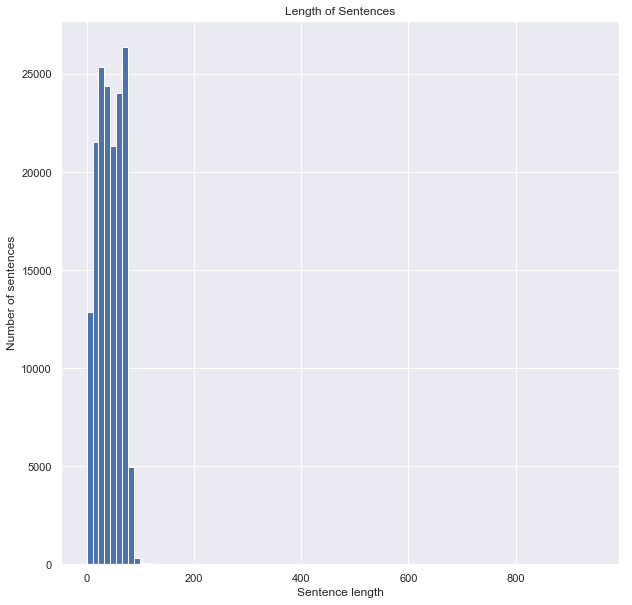

In [7]:
train_df_iq = pd.DataFrame(y)
train_df_iq[3] = processed_train_comments

print(train_df_iq[3].str.split().str.len().mean())
print(train_df_iq[3].str.split().str.len().max())
train_df_iq["strlen"] = train_df_iq[3].str.split().str.len()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Sentences')
plt.hist(train_df_iq["strlen"], bins=86)
plt.show()

In [8]:
train_df_iq.describe()

,0,1,2,strlen
count,161297.000000,161297.000000,161297.000000,161297.000000
mean,0.248455,0.089004,0.662542,42.503233
std,0.432118,0.284750,0.472844,22.673993
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,24.000000
50%,0.000000,0.000000,1.000000,42.000000
75%,0.000000,0.000000,1.000000,62.000000
max,1.000000,1.000000,1.000000,946.000000


In [9]:
_a = train_df_iq.loc[train_df_iq["strlen"] >= 1000].strlen.count()
_b = train_df_iq.loc[train_df_iq["strlen"] >= 750].strlen.count()
_c = train_df_iq.loc[train_df_iq["strlen"] >= 250].strlen.count()
_d = train_df_iq.loc[train_df_iq["strlen"] >= 180].strlen.count()
_e = train_df_iq.loc[train_df_iq["strlen"] >= 100].strlen.count()
_f = train_df_iq.loc[train_df_iq["strlen"] < 100].strlen.count()
print (" # of Reviews by Length \n %s >1000 words \n %s >750 words \n %s >250 words \n %s >180 words \n %s >100 words \n %s <100 words\n" % (_a,_b,_c,_d,_e,_f))

 # of Reviews by Length 
 0 >1000 words 
 1 >750 words 
 30 >250 words 
 68 >180 words 
 256 >100 words 
 161041 <100 words



New word count mean: 42.30497929175955
New word count max: 100


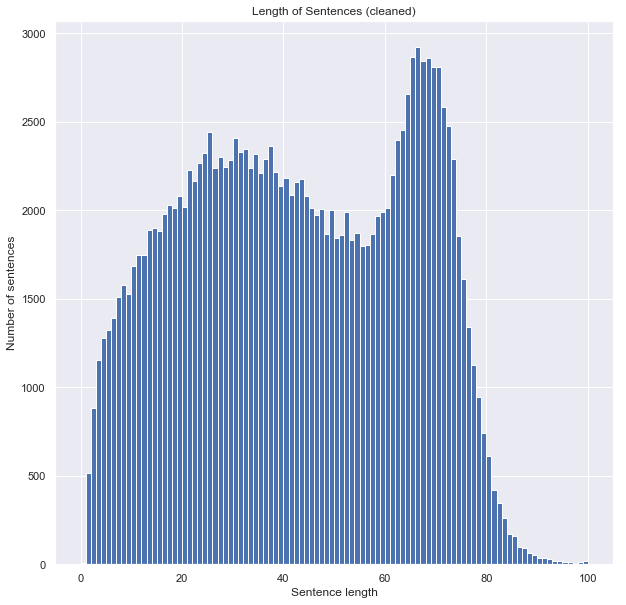

In [10]:
# Drop long rows
train_df_iq = train_df_iq.loc[train_df_iq["strlen"] <= MAX_SEQUENCE_LENGTH]

print("New word count mean:", train_df_iq[3].str.split().str.len().mean())
print("New word count max:",train_df_iq[3].str.split().str.len().max())
train_df_iq.describe()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Sentences (cleaned)')
plt.hist(train_df_iq["strlen"], bins=MAX_SEQUENCE_LENGTH)
plt.show()

##  Drop unwanted columns and Inspect Data


In [11]:
post_processed_train_comments = train_df_iq[3].tolist()
post_processed_y = train_df_iq[[0, 1, 2]].values

print('y: \n',y[0:5])
print('post_y: \n',post_processed_y[0:5])

print('pre_train comments: \n',processed_train_comments[0:3])
print('post_train comments: \n',post_processed_train_comments[0:3])

print('y_test:\n',y_test_predicted[0:5])
print('x_test:\n',processed_test_comments[0:3])

y: 
 [[0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]]
post_y: 
 [[0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]]
pre_train comments: 
 ['side effect take combin n mg fish oil', 'son halfway fourth week becam concern began last week start take highest dose fotwo day could hard get bed cranki slept fonear n hour drive home school vacat unusu fohim call doctoon monday morn said stick day see school get morn last two day problem free much agreeabl eve less emot good thing less cranki rememb thing overal behavioi bett tri mani differ medic fathi effect', 'use take anotheor n pill cycl happi light period max n day othesid effect contain hormon gestoden avail us switch ingredi simila othepil end start immedi first day period instruct said period last fotwo week take second pack two week third pack thing got even wors third period last fotwo week itn end third week still daili brown discharg posit side didnnt othesid effect idea period free tempt ala']
post_train comments: 
 ['side effect take combi

## Create vector with features and vector with encoded label


In [12]:
# MAX_NB_WORDS is set at top
# MAX_SEQUENCE_LENGTH is set at top. 

# Tokenize the data
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, split=' ', char_level=False, 
                      oov_token=None, document_count=0)

tokenizer.fit_on_texts(post_processed_train_comments + processed_test_comments)

# Convert to sequences
train_sequences = tokenizer.texts_to_sequences(post_processed_train_comments)
test_sequences = tokenizer.texts_to_sequences(processed_test_comments)
word_index = tokenizer.word_index
print('found %s tokens in text.' %(len(word_index)))

# Ensure all sequences have the same length. 
train_data = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH)
final_test_data = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH)

# Print shapes of data. 

print(train_data.shape, '<-- shape of train_data ready for val/train split.')
print(final_test_data.shape, '<-- shape of final_test_data ready for fedding to network.')
print(len(word_index), '<-- Length of Word Index')

found 111463 tokens in text.
(161047, 100) <-- shape of train_data ready for val/train split.
(53766, 100) <-- shape of final_test_data ready for fedding to network.
111463 <-- Length of Word Index


## Train/Validation split

In [13]:
# Split Training & Validation Data
print('creating train and validation data by dividing train_data in 80:20 ratio')
######################################################

X_train, X_val, Y_train, Y_val = train_test_split(train_data, post_processed_y,
                                                  test_size = 0.2,  stratify= post_processed_y, 
                                                  random_state = 2018)
X_test = final_test_data
Y_test = y_test_predicted

######################################################
print('train data shape:', X_train.shape)
print('validation data shape:', X_val.shape)
print('Data is ready for training!!')

creating train and validation data by dividing train_data in 80:20 ratio
train data shape: (128837, 100)
validation data shape: (32210, 100)
Data is ready for training!!


## Set up model


In [14]:
#import tensorflow as tf
#tf.Session()

In [15]:
#!pip list
#!pip install tensorflow-gpu 

In [16]:
# config = tf.ConfigProto( device_count = {'GPU': 1, 'CPU': 1} ) 
# sess = tf.Session(config=config) 
#keras.backend.set_session(sess)
#device = sess.list_device()

In [17]:
# import tensorflow as tf
# init = tf.global_variables_initializer()
# sess.run(init)
# tf.initialize_all_variables().run(session = sess)

In [18]:
# Make sure tensorflow is running and sees the GPU's 
# from tensorflow.python.client import device_lib

In [19]:
nb_words  = min(MAX_NB_WORDS, len(word_index))
lstm_out = MAX_SEQUENCE_LENGTH

model = Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(50))
#model.add(Attention(MAX_SEQUENCE_LENGTH))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 160)          480000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                42200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 522,353
Trainable params: 522,353
Non-trainable params: 0
_________________________________________________________________


## Fit on dataset


In [21]:
training_cycle = 1
batch = 32 
stamp = '{}trainging_cycle{}batchsize_{}'.format(title,training_cycle,batch)
print(stamp)

Drug_Data_LSTM_w_stopwords_1.0_trainging_cycle1batchsize_32


In [22]:
training_cycle = 1
batch = 32 

stamp = '{}trainging_cycle{}batchsize_{}'.format(title,training_cycle,batch)
print(stamp)
best_model_path = title + stamp + 'best.h5'

early_stopping = EarlyStopping(patience = 4)
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only = True)


# Run LSTM Model
epoch = 40
LSTM_model = model.fit(X_train, Y_train, batch_size=batch, epochs=epoch,
                       validation_data=(X_val, Y_val), shuffle = True, 
                       callbacks = [early_stopping, model_checkpoint], verbose = 0)
best_score = min(LSTM_model.history['val_loss'])


# Save Training History
df_fit = pd.DataFrame(columns=['loss','acc','val_loss','val_acc'])
df_fit['loss'] = LSTM_model.history['loss']
df_fit['val_loss'] = LSTM_model.history['val_loss']
df_fit['acc'] = LSTM_model.history['acc']
df_fit['val_acc'] = LSTM_model.history['val_acc']
df_fit

# Save Model & Run Data 
save_name = ('DrugDataLSTM_batch_{}_epoch_{}_cycle_{}'.format(batch,epoch,training_cycle))
# Save the end model with the best score. 
model.save('{}_end.h5'.format(save_name))
print('Uploaded file {}.h5'.format(save_name))
# Save df of run performance
df_fit.to_csv('{}.csv'.format(save_name))
print('Uploaded file {}.csv'.format(save_name))

# GOOGLE COLAB SAVING
#uploaded = drive.CreateFile({'title': '{}.h5'.format(save_name)})
#model.save('{}.h5'.format(save_name))
#uploaded.SetContentFile('{}.h5'.format(save_name))
#uploaded.Upload()
#print('Uploaded file {}.h5'.format(save_name),'with ID {}'.format(uploaded.get('id')))

#uploaded = drive.CreateFile({'title': '{}.csv'.format(save_name)})
#df_fit.to_csv('{}.csv'.format(save_name))
#uploaded.SetContentFile('{}.csv'.format(save_name))
#uploaded.Upload()
#print('Uploaded file {}.csv'.format(save_name),'with ID {}'.format(uploaded.get('id')))

'''Brief Performance History from runs w/stopwords and no stemming
# initial param batch=32, epoch=10
#Epoch 5/5 (256 batch size)
#102455/102455 [==============================] - 286s 3ms/step - loss: 0.2414 - acc: 0.8999 - val_loss: 0.3141 - val_acc: 0.8696

#Epoch 1-5 (64 batch size)
Train on 102455 samples, validate on 25614 samples
102455/102455 [==============================] - 416s 4ms/step - loss: 0.2463 - acc: 0.8982 - val_loss: 0.3142 - val_acc: 0.8693

#sentiment_with_lstm_1.00_8.00
#Train on 102455 samples, validate on 25614 samples
#Epoch 1/30
#102455/102455 [==============================] - 1808s 18ms/step - loss: 0.1472 - acc: 0.9429 - val_loss: 0.3224 - val_acc: 0.8833'''

Drug_Data_LSTM_w_stopwords_1.0_trainging_cycle1batchsize_32
Uploaded file DrugDataLSTM_batch_32_epoch_40_cycle_1.h5
Uploaded file DrugDataLSTM_batch_32_epoch_40_cycle_1.csv


'Brief Performance History from runs w/stopwords and no stemming\n# initial param batch=32, epoch=10\n#Epoch 5/5 (256 batch size)\n#102455/102455 [==============================] - 286s 3ms/step - loss: 0.2414 - acc: 0.8999 - val_loss: 0.3141 - val_acc: 0.8696\n\n#Epoch 1-5 (64 batch size)\nTrain on 102455 samples, validate on 25614 samples\n102455/102455 [==============================] - 416s 4ms/step - loss: 0.2463 - acc: 0.8982 - val_loss: 0.3142 - val_acc: 0.8693\n\n#sentiment_with_lstm_1.00_8.00\n#Train on 102455 samples, validate on 25614 samples\n#Epoch 1/30\n#102455/102455 [==============================] - 1808s 18ms/step - loss: 0.1472 - acc: 0.9429 - val_loss: 0.3224 - val_acc: 0.8833'

In [ ]:
training_cycle = 1
batch = 16 
epoch = 6
# Save Training History
df_fit = pd.DataFrame(columns=['loss','acc','val_loss','val_acc'])
df_fit['loss'] = LSTM_model.history['loss']
df_fit['val_loss'] = LSTM_model.history['val_loss']
df_fit['acc'] = LSTM_model.history['acc']
df_fit['val_acc'] = LSTM_model.history['val_acc']
df_fit

# Save Model & Run Data 
save_name = ('DrugDataLSTM_batch_{}_epoch_{}_cycle_{}'.format(batch,epoch,training_cycle))

uploaded = drive.CreateFile({'title': '{}.h5'.format(save_name)})
model.save('{}.h5'.format(save_name))
uploaded.SetContentFile('{}.h5'.format(save_name))
uploaded.Upload()
print('Uploaded file {}.h5'.format(save_name),'with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': '{}.csv'.format(save_name)})
df_fit.to_csv('{}.csv'.format(save_name))
uploaded.SetContentFile('{}.csv'.format(save_name))
uploaded.Upload()
print('Uploaded file {}.csv'.format(save_name),'with ID {}'.format(uploaded.get('id')))

In [ ]:
print('DrugDataLSTM_batch_{}_epoch_{}_cycle_{}'.format(batch,epoch,training_cycle))

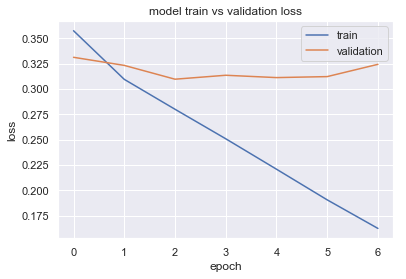

In [23]:
# Plot training vs validation loss over epoch. 

plt.plot(LSTM_model.history['loss'])
plt.plot(LSTM_model.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

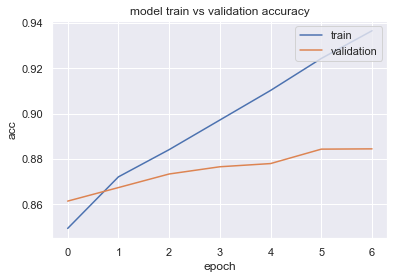

In [24]:
plt.plot(LSTM_model.history['acc'])
plt.plot(LSTM_model.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Adjust validation data en fit to data


In [26]:
accr = model.evaluate(X_test,Y_test, batch_size = 256)

53766/53766 [==============================] - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ET

# Check against test data

In [27]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.324
  Accuracy: 0.884


In [28]:
#test_sequences = tok.texts_to_sequences(X_test)
#test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

prediction = model.predict(X_test)

In [36]:
target_names = ['Positive','Neutral','Negative']
print(confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1)))

[[10612   811  2074]
 [ 1440  1686  1703]
 [ 2370  1187 31883]]


In [33]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    #plt.ylabel('True label', fontsize=30)
    #plt.xlabel('Predicted label', fontsize=30)

    return plt

In [49]:
print(Y_test.argmax(axis=1)[0:10])

[2 2 2 2 2 0 1 2 2 0]


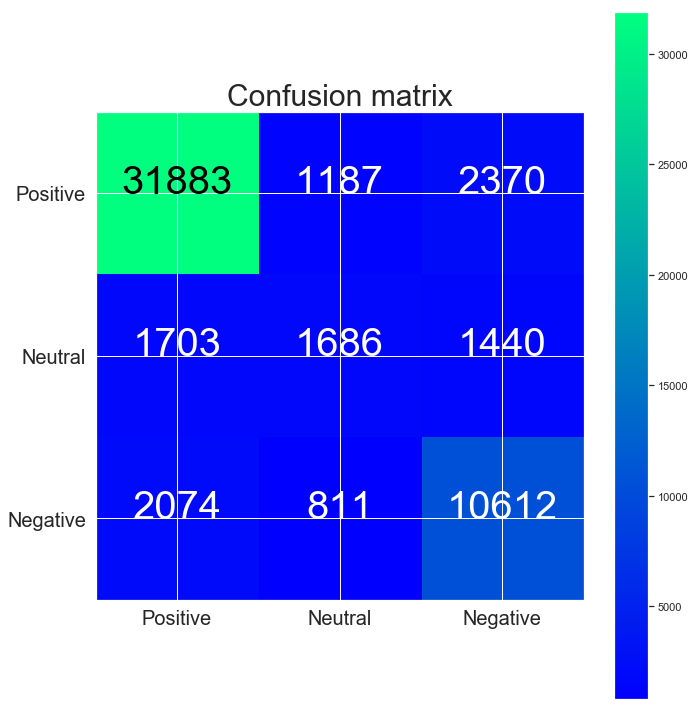

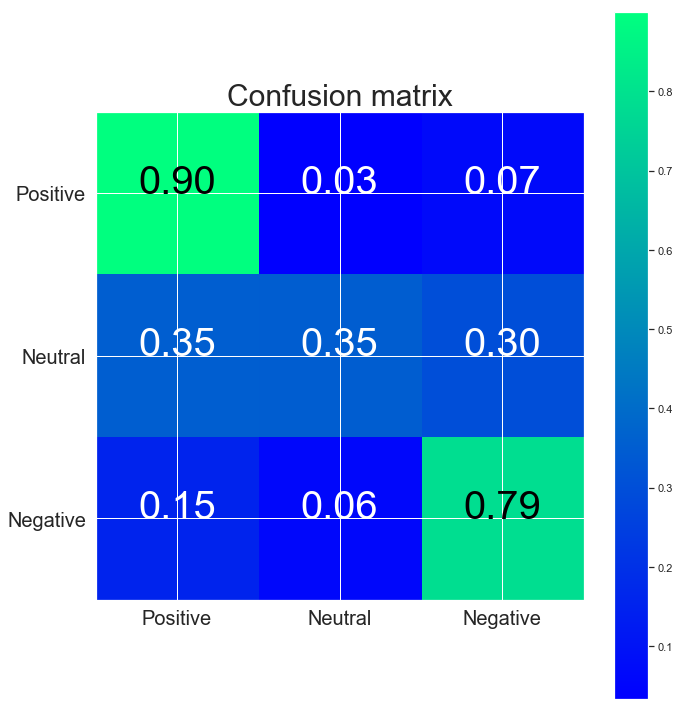

Incase we've forgotten
Test Data Value Counts:
 Positive    35440
Negative    13497
Neutral      4829
Name: classes_to_predict, dtype: int64


In [79]:
cm = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1), labels = [2,1,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()

cm = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1), labels = [2,1,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive','Neutral','Negative'], normalize=True, title='Confusion matrix')
plt.show()

print("Incase we've forgotten")
print("Test Data Value Counts:\n",test_df['classes_to_predict'].value_counts())

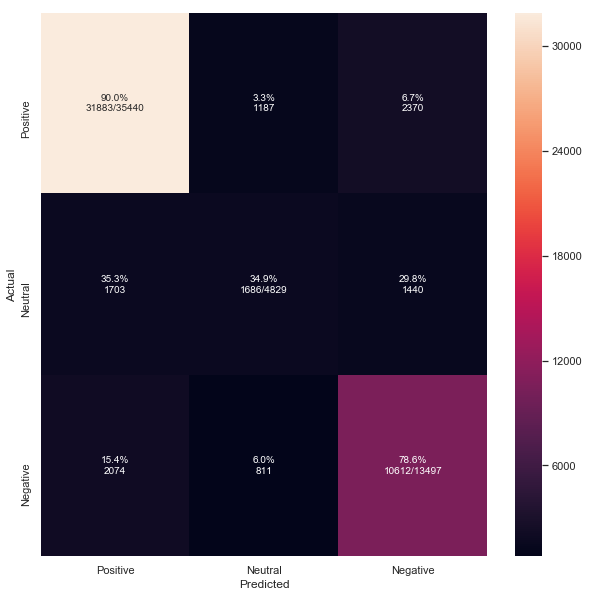

In [67]:
labels = ['Positive','Neutral','Negative']
def cm_analysis(y_true, y_pred, ymap=None, figsize=(10,10)):#labels,
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)

    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

cm_analysis(Y_test.argmax(axis=1),prediction.argmax(axis=1), ymap={0:"Negative",1:"Neutral",2:"Positive"}, figsize=(10,10))

### Notes: This network performed pretty well, and substantially better than the other networks I played with.

In [ ]:
# Download a file from Google Drive
#downloaded = drive.CreateFile({'id': "1-wo8jSg_vG76oXN8oMh9cICeuCYxGr8v"})
#downloaded.GetContentFile("batch_64_epoch_6_10_trained.h5")

In [ ]:
# Reload the saved model. 
#model = load_model('batch_64_epoch_6_10_trained.h5')

# Incorrect Graphs for presentation visualization aid

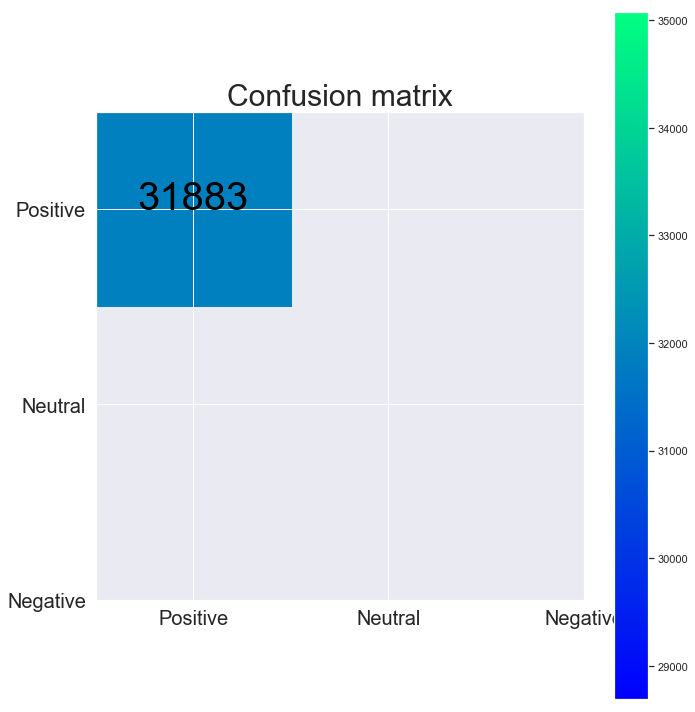

In [87]:
#HUMBUG
cm = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1), labels = [2])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()

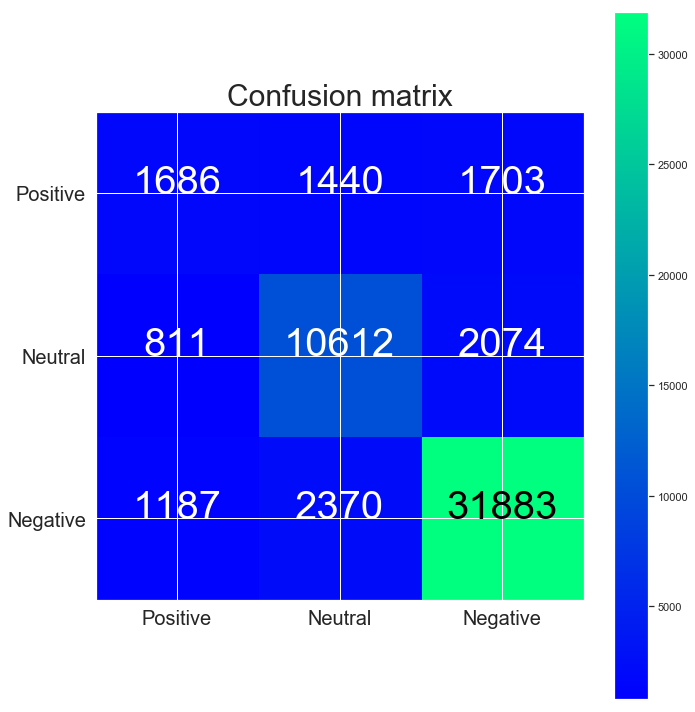

In [84]:
#DRAT
cm = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1), labels = [1,0,2])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()


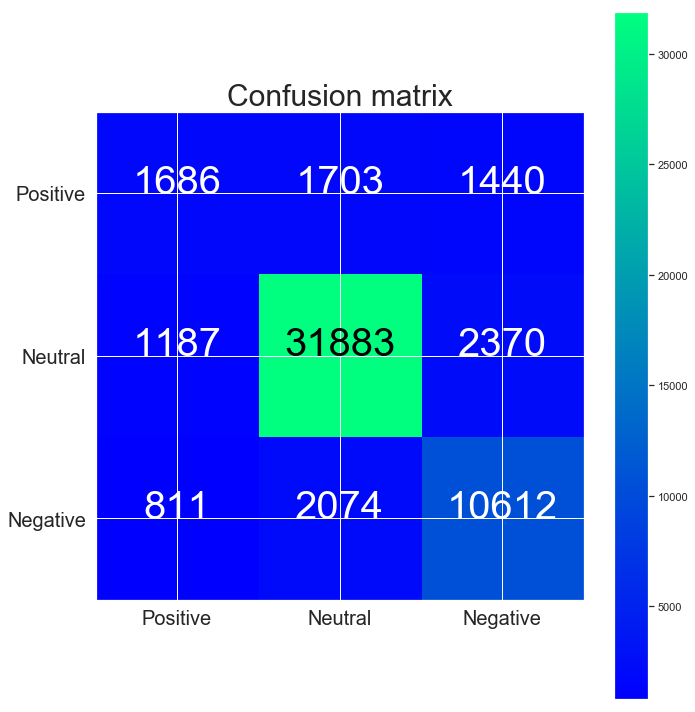

In [85]:
# DOH!
cm = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1), labels = [1,2,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()

In [86]:
# OOPS
cm = confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1), labels = [1,2,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(, classes=['Positive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()

SyntaxError: invalid syntax (<ipython-input-86-27fd0bf94233>, line 3)